# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics we use are:
- Accuracy.
- Cross-Validation Accuracy
- Cross-Validation Standard Deviation.
- ROC-AUC.

# Imports

In [22]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import cross_val_score

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Model saving
import pickle

# Extract Shapely values
import shap

c:\Users\Utente\OneDrive\Documenti\ILM\ILM-PostFinance\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading preprocessed datasets

In [7]:
# Load datasets
X_train = pd.read_csv("../database/dataset/preprocessed_dataset/X_train.csv")
y_train = pd.read_csv("../database/dataset/preprocessed_dataset/y_train.csv")
X_test = pd.read_csv("../database/dataset/preprocessed_dataset/X_test.csv")
y_test = pd.read_csv("../database/dataset/preprocessed_dataset/y_test.csv")

# Models

In [27]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [9]:
# Ensure y_train and y_test are 1D
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

In [29]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train the model on the whole training dataset this time
    model.fit(X_train, y_train)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test, y_pred)
    # Extract probabilities for the positive class (class 1)
    y_pred_prob_positive = y_pred_prob[:, 1]
    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Cross-Validation Accuracy": cv_scores.mean(),
        "Cross-Validation Std Dev": cv_scores.std(),
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
        "ROC AUC": roc_auc,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation Accuracy: 0.9824 (+/- 0.0013)

Model: Logistic Regression
Test Set Accuracy: 0.9810
ROC AUC: 0.9976
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13417
           1       0.38      0.99      0.55       158

    accuracy                           0.98     13575
   macro avg       0.69      0.98      0.77     13575
weighted avg       0.99      0.98      0.99     13575

Confusion Matrix:
[[13161   256]
 [    2   156]]



Training Naive Bayes...
Naive Bayes Cross-Validation Accuracy: 0.9843 (+/- 0.0043)

Model: Naive Bayes
Test Set Accuracy: 0.9883
ROC AUC: 0.9913
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13417
           1       0.50      0.82      0.62       158

    accuracy                           0.99     13575
   macro avg       0.75      0.90      0.8

## Summary of results

In [30]:
# Display summary results
results_df = pd.DataFrame({
    model: {
        "Test Accuracy": metrics["Accuracy"],
        "Cross-Val Accuracy": metrics["Cross-Validation Accuracy"],
        "ROC AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("Summary of Results:")
print(results_df)

Summary of Results:
                     Test Accuracy  Cross-Val Accuracy   ROC AUC
Logistic Regression       0.980994            0.982431  0.997566
Naive Bayes               0.988287            0.984298  0.991255
Decision Tree             0.995138            0.993666  0.900594
Random Forest             0.993886            0.996200  0.998415
XGBoost                   0.996759            0.997016  0.999316
LightGBM                  0.997127            0.997616  0.999456


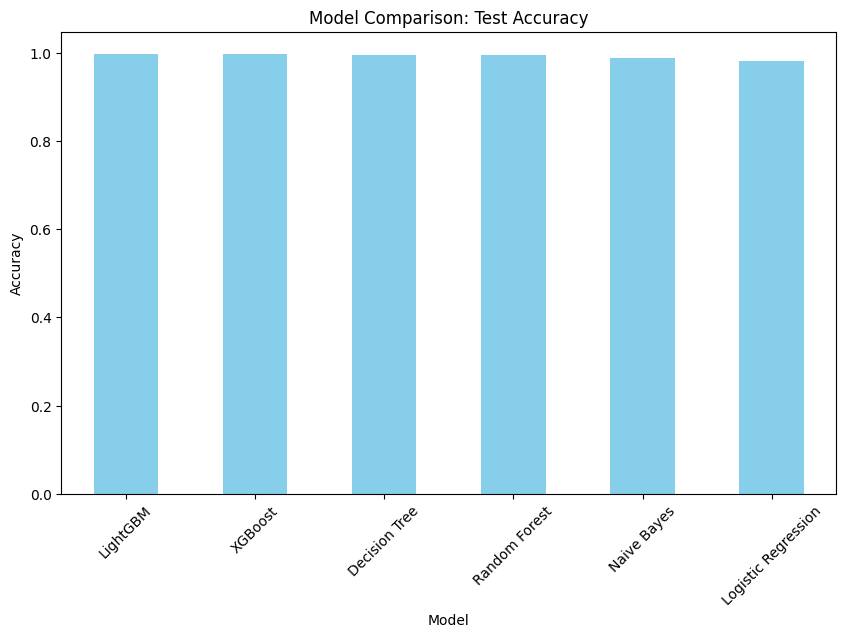

In [31]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Accuracy"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

## Analysis of Results

The LightGBM model provides key insights for predicting the eligibility of a customer.

### Train best model

In [10]:
# Train the final Random Forest model
final_model = LGBMClassifier(random_state=42)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)

[LightGBM] [Info] Number of positive: 6330, number of negative: 53663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 59993, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.105512 -> initscore=-2.137424
[LightGBM] [Info] Start training from score -2.137424


### Compute metrics of performance

In [11]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)
# Extract probabilities for the positive class (class 1)
y_pred_prob_positive = y_pred_prob[:, 1]
# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

In [12]:
# Print metrics
print(f"Final Model: LightGBM")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion)

Final Model: LightGBM
Test Set Accuracy: 0.9971
ROC AUC: 0.9995
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13417
           1       0.84      0.94      0.88       158

    accuracy                           1.00     13575
   macro avg       0.92      0.97      0.94     13575
weighted avg       1.00      1.00      1.00     13575

Confusion Matrix:
[[13388    29]
 [   10   148]]


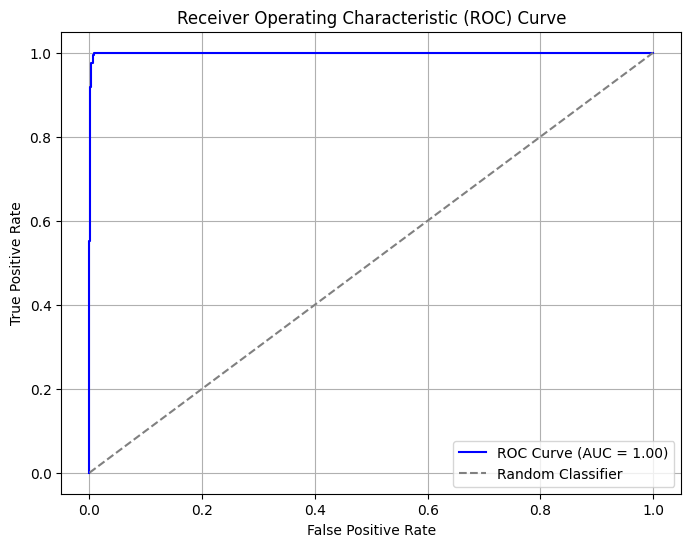

In [13]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Save the final model

In [21]:
# Create a directory for saving models
os.makedirs("../database/models", exist_ok=True)

# Save the model
with open("../database/models/lightgbm_model.pkl", "wb") as file:
    pickle.dump(final_model, file)

# Extract Shapely Values

In this step, we will extract the Shapely values from the model, and save the model to extract them.

In [23]:
# Ensure feature names are preserved for SHAP
feature_names = X_train.columns

In [25]:
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(final_model)

In [26]:
# Calculate Shapley values for the test set
shap_values = explainer(X_test)

## Visualize Shapely values

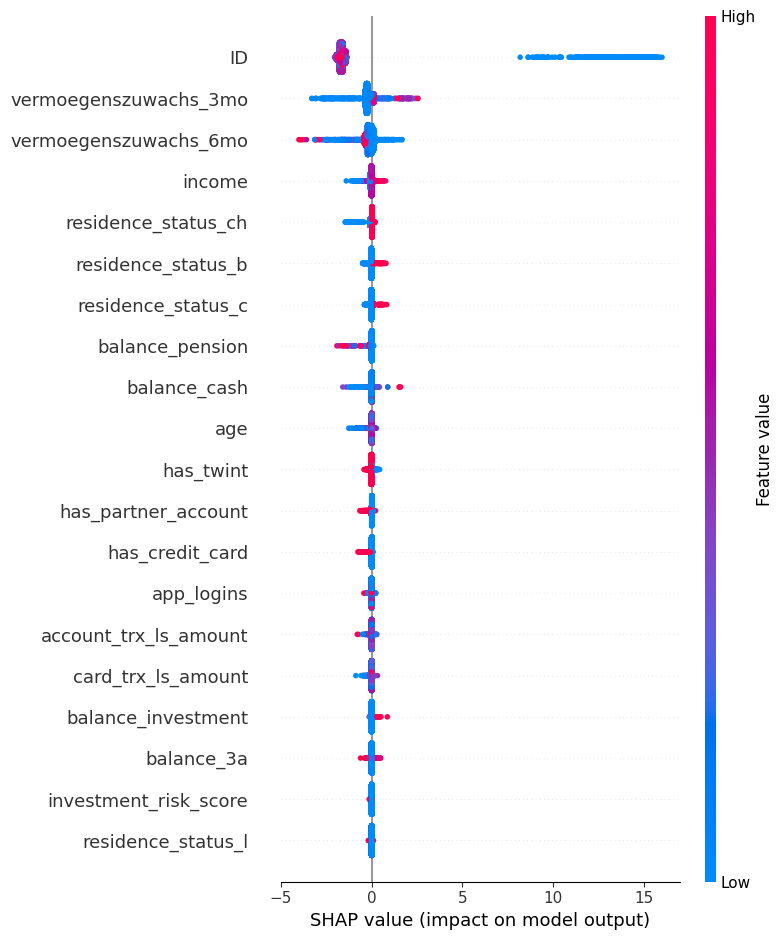

In [ ]:
# Summary Plot
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

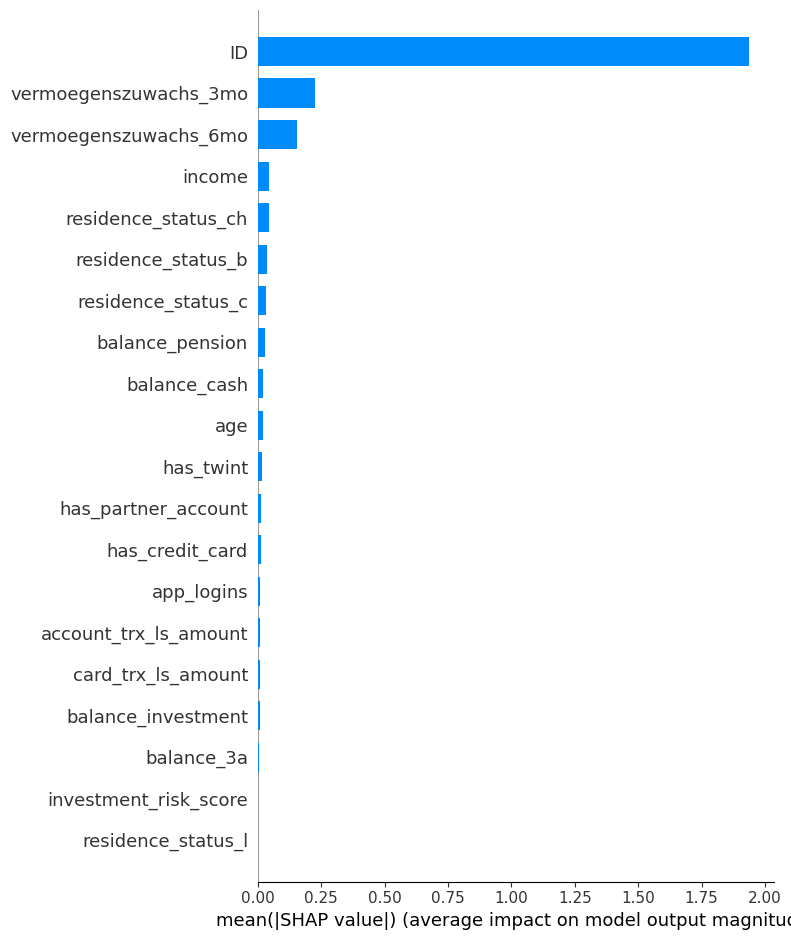

In [29]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

## Modelling and saving Shapely values

In [41]:
shap_values

.values =
array([[ 2.49075356e-03, -1.25509548e-02, -3.66907278e-03, ...,
         1.16433988e-02, -2.87816774e-04,  4.47557119e-06],
       [ 4.56845975e-04,  4.55927126e-03, -3.22839754e-03, ...,
         9.68095222e-03, -2.62017267e-04,  6.41258462e-06],
       [ 7.94975365e-03,  1.56114571e-02, -4.14790061e-03, ...,
         9.27673010e-03, -3.04391007e-04,  6.23320183e-06],
       ...,
       [-1.22327370e-02, -1.36274542e-02, -5.00512103e-03, ...,
         1.30816668e-02, -3.31465645e-04,  4.47557119e-06],
       [-5.36181448e-03, -5.23632172e-02, -4.80082559e-03, ...,
         9.84730544e-03, -3.40703294e-04,  4.33113698e-06],
       [-5.71346946e-03, -3.80944552e-02, -5.36810322e-03, ...,
         9.46441959e-03, -1.86786887e-04,  4.47557119e-06]])

.base_values =
array([-10.05733849, -10.05733849, -10.05733849, ..., -10.05733849,
       -10.05733849, -10.05733849])

.data =
array([[0.8164057748142135, -0.4903836486694355, -0.1747993190532104,
        ..., True, False, False],


In [42]:
# For binary classification, shap_values is a list of 2 arrays:
# shap_values[0]: Contributions for class 0
# shap_values[1]: Contributions for class 1
shap_values_array = shap_values.values  # Extract SHAP values for class 1

In [43]:
# Calculate the sum of absolute SHAP values for each instance
sum_abs_shap_values = np.sum(np.abs(shap_values_array), axis=1)  # Shape: (n_samples,)

In [44]:
# Sort indices based on the sum of absolute SHAP values
sorted_indices = np.argsort(-sum_abs_shap_values)  # Descending order

In [45]:
# Select indices for high and low SHAP values
indices_high_shap = sorted_indices[:2]
indices_low_shap = sorted_indices[-2:]

print("Indices with highest SHAP values:", indices_high_shap)
print("Indices with lowest SHAP values:", indices_low_shap)

Indices with highest SHAP values: [3322 2792]
Indices with lowest SHAP values: [10326 10839]


In [46]:
def generate_shap_explanation(idx):
    """Generate a DataFrame explanation for a specific customer."""
    individual = X_test.iloc[idx]
    individual_shap_values = shap_values_array[idx]
    explanation_df = pd.DataFrame({
        'Feature': feature_names,
        'Feature Value': individual.values,
        'SHAP Value': individual_shap_values
    })
    explanation_df['Customer Index'] = idx
    explanation_df['SHAP Sum'] = sum_abs_shap_values[idx]
    return explanation_df[['Customer Index', 'SHAP Sum', 'Feature', 'Feature Value', 'SHAP Value']]

In [50]:
# Generate and display explanations for high SHAP customers
print("Customers with Highest SHAP Values:")
for idx in indices_high_shap:
    explanation = generate_shap_explanation(idx)
    print(f"\nExplanation for Customer Index {idx}:")
    print(explanation.sort_values(by='SHAP Value', key=abs, ascending=False).head(10))

Customers with Highest SHAP Values:

Explanation for Customer Index 3322:
    Customer Index   SHAP Sum                Feature Feature Value  SHAP Value
15            3322  20.704188                     ID     -1.405984   15.493288
13            3322  20.704188  vermoegenszuwachs_3mo      3.732476    2.527450
14            3322  20.704188  vermoegenszuwachs_6mo      2.721101   -1.388753
6             3322  20.704188                 income      2.086672    0.379760
16            3322  20.704188     residence_status_b         False   -0.178905
17            3322  20.704188     residence_status_c         False   -0.141411
18            3322  20.704188    residence_status_ch          True    0.092971
7             3322  20.704188              has_twint      0.646975   -0.092066
1             3322  20.704188           balance_cash      2.831715    0.084423
11            3322  20.704188     card_trx_ls_amount     -0.068688    0.059060

Explanation for Customer Index 2792:
    Customer Index 

In [48]:
# Generate and display explanations for low SHAP customers
print("Customers with Lowest SHAP Values:")
for idx in indices_low_shap:
    explanation = generate_shap_explanation(idx)
    print(f"\nExplanation for Customer Index {idx}:")
    print(explanation.sort_values(by='SHAP Value', key=abs, ascending=False).head(10))

Customers with Lowest SHAP Values:

Explanation for Customer Index 10326:
    Customer Index  SHAP Sum                Feature Feature Value  SHAP Value
15           10326  1.774818                     ID     -1.385202   -1.496400
18           10326  1.774818    residence_status_ch         False   -0.096010
16           10326  1.774818     residence_status_b         False   -0.031917
6            10326  1.774818                 income      0.012501   -0.024503
17           10326  1.774818     residence_status_c         False   -0.023407
14           10326  1.774818  vermoegenszuwachs_6mo      -0.40222   -0.020536
10           10326  1.774818  account_trx_ls_amount     -1.281432   -0.012811
7            10326  1.774818              has_twint      0.646975   -0.012756
11           10326  1.774818     card_trx_ls_amount     -0.717826   -0.012526
5            10326  1.774818             app_logins      2.102921   -0.012523

Explanation for Customer Index 10839:
    Customer Index  SHAP Sum 

### Saving SHAP values for low and high SHAP customers

In [56]:
# Map sorted_indices to original indices
original_indices_high_shap = X_test.index[indices_high_shap]
original_indices_low_shap = X_test.index[indices_low_shap]

# Save explanations using original indices
for idx in original_indices_high_shap.tolist() + original_indices_low_shap.tolist():
    explanation = generate_shap_explanation(idx)
    explanation.to_csv(f"../database/shap/customers/customer_{idx}_shap_explanation.csv", index=False)
print("Saved SHAP explanations for selected customers.")

Saved SHAP explanations for selected customers.


### Saving Feature-Level SHAP Values

In [53]:
# Save SHAP values and feature names for the test set
shap_data = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_data.to_csv("../database/shap/shap_values_all_features.csv", index=False)
print("Saved SHAP values for all features.")

Saved SHAP values for all features.


### Saving SHAP Explainer

In [57]:
# Save the SHAP explainer
with open("../database/models/shap_explainer_lightgbm.pkl", "wb") as file:
    pickle.dump(explainer, file)

print("SHAP explainer model saved successfully.")

SHAP explainer model saved successfully.
